# 5.7 ELMo

Course's materials require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

replicating local resources


In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 1.x
import tensorflow as tf
tf.__version__

2025-03-31 18:53:47.644636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.12.0'

### ELMo: Embeddings from Language Models

Word embeddings such as word2vec or GloVe provides an exact meaning to words. Eventhough they provided a great improvement to many NLP task, such "constant" meaning was a major drawback of this word embeddings as the meaning of words changes based on context, and thus this wasn't the best option for Language Modelling.

For instance, after we train word2vec/Glove on a corpus we get as output one vector representation for, say the word **cell**. So even if we had a sentence like "He went to the prison **cell** with his **cell** phone to extract blood **cell** samples from inmates", where the word **cell** has different meanings based on the sentence context, these models just collapse them all into one vector for **cell** in their output [source](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

Unlike most widely used word embeddings ELMo word representations are functions of the entire input sentence, instead of the single word. They are computed on top of two-layer Bidirectional Language Models (biLMs) with character convolutions, as a linear function of the internal network states. Therefore, the same word can have different word vectors under different contexts.

[Deep contextualized word representations](https://arxiv.org/pdf/1802.05365.pdf)

[Character-level Convolutional Networks](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)

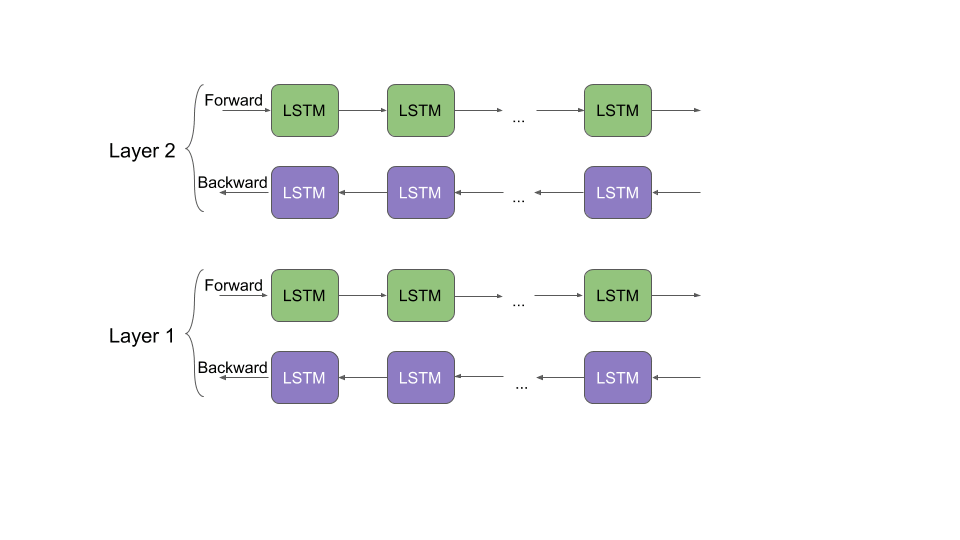

In [1]:
from IPython.display import Image
#Image(filename='local/imgs/ELMo.gif', width=1200)
Image(open('local/imgs/ELMo.gif','rb').read())

[Image taken from here](https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/)

Given $T$ tokens $(x_1,x_2,\cdots,x_T)$, a forward language model computes the probability of the sequence by modeling the probability of token $x_k$ given the history $(x_1,\cdots, x_{k-1})$. This formulation has been addressed in the state of the art using many different approach, and more recently including some approximation based on Bidirectional Recurrent Networks.

ELMo is inspired in the Language Modelling problem, which has the advantage of being a **self-supervised** task.

A practical implication of this difference is that we can use word2vec and Glove vectors trained on a large corpus directly for downstream tasks. All we need is the vectors for the words. There is no need for the model itself that was used to train these vectors.

However, in the case of ELMo and BERT (we will see it in a forthcoming lecture), since they are context dependent, we need the model that was used to train the vectors even after training, since the models generate the vectors for a word based on context. [source](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

#### Let's see how to define a simplified ELMo version from scratch:

In [3]:
def Char_CNN(vocab_size, input_size = 120, embedding_size=32):
    # parameter
    conv_layers = [[8, 3, 2],
                   [8, 3, 2],
                   [8, 3, -1],#]
                   [8, 3, -1]]
    
    fully_connected_layers = [64, 64]
    dropout_p = 0.5
    
    # Embedding layer Initialization
    embedding_layer = Embedding(vocab_size + 1,
                                embedding_size,
                                input_length=input_size,mask_zero=True)

    # Model Construction
    
    # Input
    inputs = Input(shape=(input_size,), name='input_c', dtype='int64')  # shape=(?, 1014)
    
    # Embedding
    x = embedding_layer(inputs)
    
    # Conv
    for filter_num, filter_size, pooling_size in conv_layers:
        x = Conv1D(filter_num, filter_size)(x)
        x = Activation('relu')(x)
        if pooling_size != -1:
            x = MaxPooling1D(pool_size=pooling_size)(x)  # Final shape=(None, 34, 256)
    x = Flatten()(x)  # (None, 8704)
    
    # Fully connected layers
    
    for dense_size in fully_connected_layers:
        x = Dense(dense_size, activation='relu')(x)  # dense_size == 1024
        x = Dropout(dropout_p)(x)
    
    Char_CNN_Embeddings = Model(inputs=inputs, outputs=x)
    return Char_CNN_Embeddings

In [ ]:
#Define model on top of Char_CNN: sentiment as input
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Dense, TimeDistributed, Embedding, Conv1D, Activation
from tensorflow.keras.models import Model

Input_elmo = Input(shape=(input_text_charact_padded[0].shape[0],input_text_charact_padded[0].shape[1],), name='input_s')

CNN_Embeddings = Char_CNN(len(tk.word_index), input_size = word_max_length, embedding_size=32)
embedding = TimeDistributed(CNN_Embeddings)(Input_elmo)

x = Bidirectional(LSTM(units=128, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

x_add = add([x, x_rnn])  # residual connection to the first biLSTM

#----------------ELMo ends here -------------------------------------
#-------------------------------------------------------------------- 

x_dense = TimeDistributed(Dense(16, activation="relu"))(x_add)
out_1 = TimeDistributed(Dense(1, activation="sigmoid"))(x_dense)

model2 = Model(inputs=[Input_elmo], outputs=[out_1])

We can also use pre-trained ELMo from tensorflow hub repository.

## Download the model

Let's load ELMo model. This will take some time because the model is over 350 Mb in size

In [2]:
import tensorflow_hub as hub
import tensorflow as tf

#gpus= tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
#elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
# In TEnsorFlow 2 the statement should be something like this
elmo_model = hub.KerasLayer("https://tfhub.dev/google/elmo/2")

In [6]:
embeddings = elmo_model(["i like green eggs and ham",
                   "would you eat them in a box"],
                  signature="default",
                  as_dict=True)["elmo"]
print(embeddings.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(2, 7, 1024)


## Name Entity Recognition (NER)

NER is a sequential labeling problem where the aim is to label every word in a sentence of pargraph, according to a list of "entity" classes. This is different from part of Speech (POS) tagging, which explains how a word is used in a sentence [For more information about POS](https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb). 

Tipical labels in NER are:

In [7]:
import nltk
nltk.download('maxent_ne_chunker')
chunker=nltk.data.load(nltk.chunk._MULTICLASS_NE_CHUNKER)
sorted(chunker._tagger._classifier.labels())

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


['B-FACILITY',
 'B-GPE',
 'B-GSP',
 'B-LOCATION',
 'B-ORGANIZATION',
 'B-PERSON',
 'I-FACILITY',
 'I-GPE',
 'I-GSP',
 'I-LOCATION',
 'I-ORGANIZATION',
 'I-PERSON',
 'O']

GPE stands for Geo-Political Entity, GSP stands for Geographical-Social-Political Entity. and there are other definitions of labels that include more classes [Detailed info can be found here](https://www.ldc.upenn.edu/sites/www.ldc.upenn.edu/files/english-entities-guidelines-v6.6.pdf). 

NER task is commonly viewed as a sequential prediction problem in which we aim at assigning the correct label for each token. Different ways of encoding information in a set of labels make different chunk representation. The two most popular schemes are BIO and BILOU [source](https://natural-language-understanding.fandom.com/wiki/Named_entity_recognition).

- BIO stands for Beginning, Inside and Outside (of a text segment).
- Similar but more detailed than BIO, BILOU encode the Beginning, the Inside and Last token of multi-token chunks while differentiate them from Unit-length chunks

In [8]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("local/data/ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

,Sentence #,Word,Tag
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O


In [9]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [10]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [11]:
tags

['B-org',
 'I-org',
 'B-art',
 'I-geo',
 'I-art',
 'I-gpe',
 'I-per',
 'I-tim',
 'B-nat',
 'I-eve',
 'B-geo',
 'B-per',
 'I-nat',
 'B-gpe',
 'O',
 'B-tim',
 'B-eve']

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [14]:
sentences = getter.sentences
print(len(sentences))

47959


In [15]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


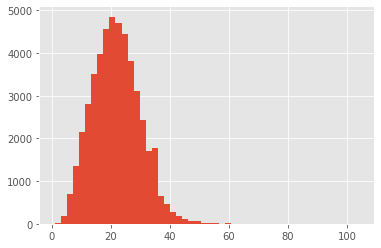

In [16]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [17]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

11193
10


ELMo embedding represents every word as 1024 feature vector. Therefore, in order to reduce the computational complexity and based on the former histogram, we can truncate the sequences to a maximum length of 50.

In [0]:
max_len = 50

In [19]:
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [20]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

Using TensorFlow backend.


array([13, 14, 14, 11,  6,  6,  6, 14, 14, 14, 14, 14, 15, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
      dtype=int32)

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [0]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [0]:
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

This is how we have to define the layer in order to be used in the model (In TF 2.x this should not be necessary [take a look to this guide](https://www.tensorflow.org/hub)):

In [0]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [0]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

## Excercise 1: Complete the model arquitecture

After the Embedding layer include two Bidirectional LSTM layers with 512 cells each. The second layer must be on top of the first one. As output layer include a Dense layer which takes as input the sum of the two Bidirectional layers output's. Remember that in NER the output must be a sequence of same length  as the input.

In [29]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Split data into training and validation subsets, use both during training to evaluate training and validation accuracies.

In [0]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

Train the model using a batch_size = 32 and 5 epochs. Use verbose=1 to see the evolution of the training process.

In [33]:
model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/5
38816/38816 [==============================] - 542s 14ms/step - loss: 0.0584 - accuracy: 0.9828 - val_loss: 0.0415 - val_accuracy: 0.9867
Epoch 2/5
38816/38816 [==============================] - 542s 14ms/step - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.0329 - val_accuracy: 0.9889
Epoch 3/5
38816/38816 [==============================] - 542s 14ms/step - loss: 0.0347 - accuracy: 0.9884 - val_loss: 0.0267 - val_accuracy: 0.9907
Epoch 4/5
38816/38816 [==============================] - 540s 14ms/step - loss: 0.0291 - accuracy: 0.9899 - val_loss: 0.0208 - val_accuracy: 0.9927
Epoch 5/5
38816/38816 [==============================] - 541s 14ms/step - loss: 0.0242 - accuracy: 0.9914 - val_loss: 0.0169 - val_accuracy: 0.9943


In [34]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=b57be0c86874a72d5b1d198068cbc96e97ae0f762a26f7aa52c3ef7b099cf4b0
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [35]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 48s 10ms/step


In [0]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [37]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.6%


In [38]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      geo       0.85      0.90      0.87      3720
      per       0.74      0.77      0.76      1677
      tim       0.86      0.86      0.86      2148
      gpe       0.96      0.94      0.95      1591
      org       0.69      0.70      0.70      2061
      eve       0.22      0.36      0.27        33
      art       0.38      0.10      0.16        49
      nat       0.33      0.18      0.24        22

micro avg       0.82      0.84      0.83     11301
macro avg       0.82      0.84      0.83     11301



Let's see the predictions for one sequence:

In [45]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-org (B-org)
Government     :I-org (I-org)
Accountability :I-org (O)
office         :O     (O)
,              :O     (O)
The            :B-org (B-org)
New            :I-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :O     (O)
Iraq           :B-geo (B-geo)
's             :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :O     (O)
the            :O     (O)
pa

### Lest's compare the result with a simple Embedding layer instead of ELMo 

For the sake of comparison, create a model using a conventional Embedding layer, instead of ELMo model. We are going to use an output dimension of 1024 for the Embedding layer and 10000 words dictionary for tokanization.

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        #agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]}
        input_func = lambda s: " ".join(w for w in s["Word"].values.tolist())
        ouput_func = lambda s: " ".join(t for t in s["Tag"].values.tolist())
        self.in_grouped = self.data.groupby("Sentence #").apply(input_func)
        self.out_grouped = self.data.groupby("Sentence #").apply(ouput_func)
        self.input_sentences = [s for s in self.in_grouped]
        self.output_targets = [s for s in self.out_grouped]
    
    def get_next(self):
        try:
            i = self.in_grouped["Sentence: {}".format(self.n_sent)]
            o = self.out_grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return i,o
        except:
            return None

In [0]:
getter = SentenceGetter(data)
sent_input, out_put = getter.get_next()

In [52]:
sentences = getter.input_sentences
targets = getter.output_targets
print(len(sentences))
print(len(targets))

47959
47959


In [53]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w] for w in s.split(' ')] for s in targets]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([13, 14, 14, 11,  6,  6,  6, 14, 14, 14, 14, 14, 15, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
      dtype=int32)

In [0]:
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer(num_words=10000)
# fit the tokenizer on the documents
word_tokenizer.fit_on_texts(sentences)

In [60]:
# summarize what was learned
print(word_tokenizer.word_counts)
print(word_tokenizer.document_count)
print(word_tokenizer.word_index)
print(word_tokenizer.word_docs)
# integer encode documents
encoded_docs = word_tokenizer.texts_to_sequences(sentences)
#print(encoded_docs)

OrderedDict([('thousands', 495), ('of', 26394), ('demonstrators', 132), ('have', 5487), ('marched', 65), ('through', 519), ('london', 280), ('to', 23322), ('protest', 238), ('the', 63916), ('war', 994), ('in', 28098), ('iraq', 1749), ('and', 20147), ('demand', 221), ('withdrawal', 154), ('british', 648), ('troops', 1202), ('from', 4557), ('that', 6437), ('country', 1948), ('iranian', 402), ('officials', 3390), ('say', 4178), ('they', 2397), ('expect', 66), ('get', 170), ('access', 127), ('sealed', 19), ('sensitive', 30), ('parts', 169), ('plant', 111), ('wednesday', 1258), ('after', 2740), ('an', 4236), ('iaea', 73), ('surveillance', 51), ('system', 267), ('begins', 51), ('functioning', 11), ('helicopter', 110), ('gunships', 18), ('saturday', 1152), ('pounded', 15), ('militant', 461), ('hideouts', 16), ('orakzai', 19), ('tribal', 170), ('region', 858), ('where', 658), ('many', 600), ('taliban', 288), ('militants', 1065), ('are', 3721), ('believed', 175), ('fled', 154), ('avoid', 82), (

In [62]:
len(encoded_docs[0])

23

In [63]:
NewX = pad_sequences(maxlen=max_len, sequences=encoded_docs, padding="post", value=0)
NewX[15]

array([ 110,   33,   26,   98,   56, 1649,  834,   32, 5699,    5,  780,
       3788,   76,    4,  543,    5, 4299, 6304,    2,   30, 1720, 1121,
         84, 1236,    8,    5, 3083, 2845, 1275,   52,   97,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(NewX, y, test_size=0.1, random_state=2018)

In [0]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [0]:
from keras.layers import Embedding

In [0]:
input_text = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=1024, mask_zero=True)(input_text)
# Complete the model architecture here:
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [0]:
model2 = Model(input_text, out)
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [70]:
model2.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/5
38816/38816 [==============================] - 325s 8ms/step - loss: 0.1924 - accuracy: 0.9462 - val_loss: 0.1502 - val_accuracy: 0.9532
Epoch 2/5
38816/38816 [==============================] - 323s 8ms/step - loss: 0.1361 - accuracy: 0.9569 - val_loss: 0.1384 - val_accuracy: 0.9572
Epoch 3/5
38816/38816 [==============================] - 323s 8ms/step - loss: 0.1165 - accuracy: 0.9618 - val_loss: 0.1383 - val_accuracy: 0.9576
Epoch 4/5
38816/38816 [==============================] - 322s 8ms/step - loss: 0.0995 - accuracy: 0.9663 - val_loss: 0.1418 - val_accuracy: 0.9582
Epoch 5/5
38816/38816 [==============================] - 320s 8ms/step - loss: 0.0836 - accuracy: 0.9708 - val_loss: 0.1514 - val_accuracy: 0.9579


In [77]:
X_te = X_te[:149*batch_size,:]
test_pred = model2.predict(np.array(X_te), verbose=1)

4768/4768 [==============================] - 18s 4ms/step


In [0]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [79]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 54.5%


In [80]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      geo       0.63      0.52      0.57      3720
      per       0.51      0.46      0.48      1677
      tim       0.59      0.50      0.54      2148
      gpe       0.80      0.68      0.73      1591
      org       0.49      0.38      0.42      2061
      eve       0.20      0.12      0.15        33
      art       0.08      0.02      0.03        49
      nat       0.19      0.18      0.19        22

micro avg       0.60      0.50      0.55     11301
macro avg       0.60      0.50      0.54     11301



<font color=red>**Note the performance drop in this case!**</font>

Let's see the predictions for the same sentenced analysed before:

In [83]:
i = 390
p = model2.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
           2327:O     (O)
              5:O     (O)
           1604:O     (O)
            144:O     (O)
             21:O     (O)
              1:O     (O)
             14:O     (B-org)
             20:B-geo (I-org)
             34:O     (O)
           8632:I-org (O)
            383:I-org (O)
              1:O     (B-org)
             49:B-org (I-org)
            436:I-org (I-org)
            784:I-org (I-org)
             16:O     (O)
             95:O     (B-tim)
              1:O     (O)
           1890:O     (O)
           2436:O     (O)
              4:O     (O)
            109:O     (O)
            155:O     (O)
            583:O     (O)
             88:O     (O)
              6:O     (O)
            356:O     (O)
            583:O     (O)
             88:O     (O)
           1559:O     (B-geo)
              5:O     (O)
            125:O     (O)
              3:O     (O)
             60:O     (O)
              7:O     (O)
            827:O     (O)
  